# Multi-Class Image Classification Deep Learning Model for Weed Species Image Using TensorFlow Take 1
### David Lowe
### March 1, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Weed Species Image dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: The DeepWeeds dataset consists of 17,509 images capturing eight different weed species native to Australia in situ with neighboring flora. The selected weed species are local to pastoral grasslands across the state of Queensland. They include: "Chinee apple", "Snake weed", "Lantana", "Prickly acacia", "Siam weed", "Parthenium", "Rubber vine" and "Parkinsonia".

The research team built and tested their models using a five-fold cross-validation approach. Each fold of the dataset contains the subset of data for training (60%), validation (20%), and testing (20%). The research team set up the Python script for multi-label classification. To keep our experiments straight-forward for now, this series of exercises will focus on predicting a single class for each image.

In this Take1 iteration, we will construct a CNN model using the ResNet50 architecture and test the model's performance using one of the dataset's five subsets.

ANALYSIS: In this Take1 iteration and using the subset0 portion of the dataset, the model's performance achieved an accuracy score of 78.61% on the validation dataset after 50 epochs. Furthermore, the final model processed the test dataset with an accuracy measurement of 82.81%.

Data subset1: Validation - 73.70%, Test - 80.73%
Data subset2: Validation - 78.04%, Test - 81.43%
Data subset3: Validation - 79.59%, Test - 84.54%
Data subset4: Validation - 79.76%, Test - 84.99%

CONCLUSION: In this iteration, the ResNet50 TensorFlow CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: Weed Species Image Dataset

Dataset ML Model: Multi-class image classification with numerical attributes

Dataset Reference: https://github.com/AlexOlsen/DeepWeeds

One potential source of performance benchmarks: https://github.com/AlexOlsen/DeepWeeds

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Feb 24 22:09:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import zipfile
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
TEST_SET_SIZE = 0.2
VAL_SET_SIZE = 0.2

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
MAX_EPOCH = 50
BATCH_SIZE = 32
RAW_IMAGE_SIZE = (256, 256)
TARGET_IMAGE_SIZE = (224, 224)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

NUM_CLASSES = 9
CLASS_LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '8']
CLASS_NAMES = ['Chinee apple',
               'Lantana',
               'Parkinsonia',
               'Parthenium',
               'Prickly acacia',
               'Rubber vine',
               'Siam weed',
               'Snake weed',
               'Negative']

TRAIN_SUBSET_CSV = 'train_subset2.csv'
VAL_SUBSET_CSV = 'val_subset2.csv'
TEST_SUBSET_CSV = 'test_subset2.csv'

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.4.1


In [8]:
# Set up the parent directory location for loading the dotenv files
# Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# env_path = "/Users/david/PycharmProjects/"
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [11]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [13]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [14]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/
!rm images.zip
!rm DeepWeeds-master.zip

rm: cannot remove 'images.zip': No such file or directory
rm: cannot remove 'DeepWeeds-master.zip': No such file or directory


In [15]:
!wget https://dainesanalytics.com/datasets/tensorflow-weed-species-image/DeepWeeds-master.zip

--2021-02-24 22:09:59--  https://dainesanalytics.com/datasets/tensorflow-weed-species-image/DeepWeeds-master.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.227.219.88, 13.227.219.97, 13.227.219.49, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.227.219.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 547909 (535K) [application/zip]
Saving to: ‘DeepWeeds-master.zip’

DeepWeeds-master.zi 100%[===================>] 535.07K  --.-KB/s    in 0.03s   

2021-02-24 22:09:59 (18.6 MB/s) - ‘DeepWeeds-master.zip’ saved [547909/547909]



In [16]:
!wget https://dainesanalytics.com/datasets/tensorflow-weed-species-image/images.zip

--2021-02-24 22:09:59--  https://dainesanalytics.com/datasets/tensorflow-weed-species-image/images.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.227.219.88, 13.227.219.97, 13.227.219.49, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.227.219.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491516047 (469M) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>] 468.75M   157MB/s    in 3.0s    

2021-02-24 22:10:03 (157 MB/s) - ‘images.zip’ saved [491516047/491516047]



In [17]:
staging_dir = 'staging/'
!mkdir staging/
!mkdir staging/images/

In [18]:
# Unzip and put the files into the staging folder
local_zip = 'DeepWeeds-master.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(staging_dir)
local_zip = 'images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(staging_dir+'images/')
zip_ref.close()

In [19]:
data_dir = 'staging/images/'
labels_dir = 'staging/DeepWeeds-master/labels/'

In [20]:
train_dataframe = pd.read_csv(labels_dir+TRAIN_SUBSET_CSV)
train_dataframe['Label'] = train_dataframe['Label'].astype(str)
print(train_dataframe.head())

                Filename Label
0  20180112-070805-2.jpg     8
1  20180109-092115-2.jpg     7
2  20180119-105220-1.jpg     8
3  20161207-143329-0.jpg     7
4  20180109-075247-2.jpg     8


In [21]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_files = train_dataframe[train_dataframe['Label']==c_label]
    print('Number of training images for', CLASS_NAMES[int(c_label)], ':', len(training_class_files))
    print('Training image samples:\n', training_class_files[:5], '\n')

Number of training images for Chinee apple : 676
Training image samples:
                  Filename Label
12  20170410-124625-0.jpg     0
29  20171025-082312-1.jpg     0
32  20170811-154858-2.jpg     0
34  20170704-154059-0.jpg     0
45  20170811-112814-2.jpg     0 

Number of training images for Lantana : 638
Training image samples:
                  Filename Label
11  20170714-110439-3.jpg     1
25  20170714-120456-2.jpg     1
33  20170126-095533-0.jpg     1
71  20170714-143440-3.jpg     1
80  20170501-143847-0.jpg     1 

Number of training images for Parkinsonia : 619
Training image samples:
                   Filename Label
24   20170920-162359-3.jpg     2
76   20171102-120225-2.jpg     2
84   20171102-120924-1.jpg     2
90   20170920-101006-2.jpg     2
106  20171102-121407-1.jpg     2 

Number of training images for Parthenium : 613
Training image samples:
                  Filename Label
18  20170906-105056-1.jpg     3
39  20171025-095038-1.jpg     3
48  20171025-095830-1.jpg   

In [22]:
val_dataframe = pd.read_csv(labels_dir+VAL_SUBSET_CSV)
val_dataframe['Label'] = val_dataframe['Label'].astype(str)
print(val_dataframe.head())

                Filename Label
0  20171218-113300-3.jpg     8
1  20180105-101110-3.jpg     8
2  20170913-110506-1.jpg     3
3  20171218-104645-3.jpg     8
4  20180109-101140-2.jpg     8


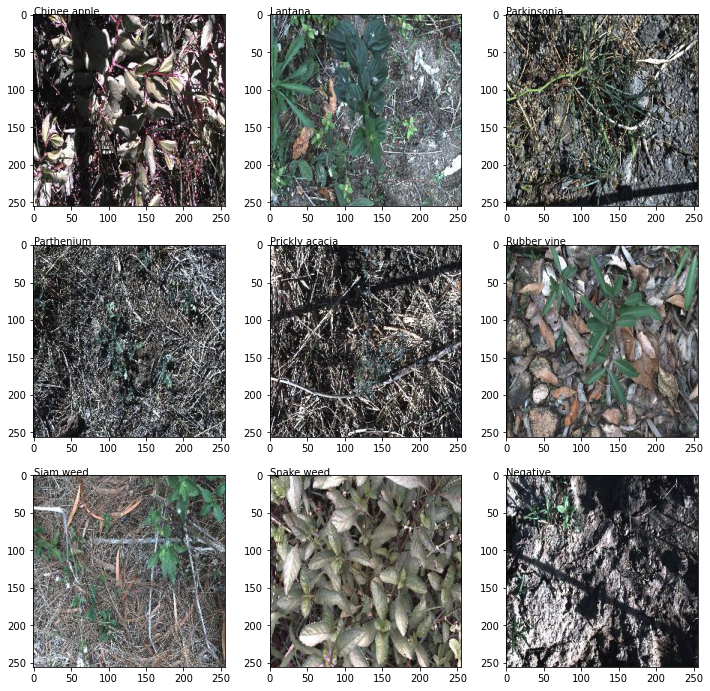

In [23]:
# Plot some training images from the dataset
nrows = 3
ncols = 3
training_examples = []

for c_label in CLASS_LABELS:
    training_class_files = train_dataframe[train_dataframe['Label']==c_label]
    training_examples.append(training_class_files.at[training_class_files.index[0],'Filename'])

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.text(0, 0, CLASS_NAMES[i])
    # sp.axis('Off')
    img = mpimg.imread(data_dir + img_path)
    plt.imshow(img)
plt.show()

In [24]:
datagen_kwargs = dict(rescale=1./255)
validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(batch_size=BATCH_SIZE, classes=CLASS_LABELS, class_mode='categorical')

do_data_augmentation = True
if do_data_augmentation:
    training_datagen = ImageDataGenerator(fill_mode="constant",
                                          shear_range=0.2,
                                          zoom_range=(0.5, 1),
                                          horizontal_flip=True,
                                          rotation_range=360,
                                          channel_shift_range=25,
                                          brightness_range=(0.75, 1.25),
                                          **datagen_kwargs)
else:
    training_datagen = validation_datagen

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_dataframe(train_dataframe,
                                                          directory=data_dir,
                                                          x_col='Filename',
                                                          y_col='Label',
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          shuffle=True,
                                                          seed=seedNum,
                                                          **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(training_generator))

print('Loading and pre-processing the validation images...')
validation_generator = validation_datagen.flow_from_dataframe(val_dataframe,
                                                              directory=data_dir,
                                                              x_col='Filename',
                                                              y_col='Label',
                                                              target_size=TARGET_IMAGE_SIZE,
                                                              shuffle=False,
                                                              **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the training images...
Found 10506 validated image filenames belonging to 9 classes.
Number of image batches per epoch of modeling: 329
Loading and pre-processing the validation images...
Found 3502 validated image filenames belonging to 9 classes.
Number of image batches per epoch of modeling: 110


In [25]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [26]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [27]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
#         if metric == train_loss:
#             plt.ylim([0, plt.ylim()[1]])
#         else:
#             plt.ylim([0.5, 1.1])
        plt.legend()

In [28]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    nn_model = keras.applications.ResNet50(include_top=True, weights=None, input_shape=input_param, classes=output_param)
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [29]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.000001)
reset_random(seedNum)
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(
    training_generator,
	validation_data=validation_generator,
    epochs=MAX_EPOCH,
    callbacks=[learning_rate_reduction],
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/50
329/329 [==============================] - 182s 527ms/step - loss: 2.0343 - accuracy: 0.4798 - val_loss: 2.5532 - val_accuracy: 0.5200
Epoch 2/50
329/329 [==============================] - 174s 530ms/step - loss: 1.4498 - accuracy: 0.5259 - val_loss: 1.5052 - val_accuracy: 0.5203
Epoch 3/50
329/329 [==============================] - 173s 527ms/step - loss: 1.2961 - accuracy: 0.5538 - val_loss: 1.4634 - val_accuracy: 0.5314
Epoch 4/50
329/329 [==============================] - 174s 529ms/step - loss: 1.1931 - accuracy: 0.5781 - val_loss: 2.5930 - val_accuracy: 0.3015
Epoch 5/50
329/329 [==============================] - 173s 526ms/step - loss: 1.2053 - accuracy: 0.5794 - val_loss: 1.7381 - val_accuracy: 0.5460
Epoch 6/50
329/329 [==============================] - 175s 531ms/step - loss: 1.1916 - accuracy: 0.5882 - val_loss: 1.8766 - val_accuracy: 0.3132
Epoch 7/50
329/329 [==============================] - 173s 526ms/step - loss: 1.1676 - accuracy: 0.5967 - val_loss: 1.8283 -

In [30]:
nn_model_0.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

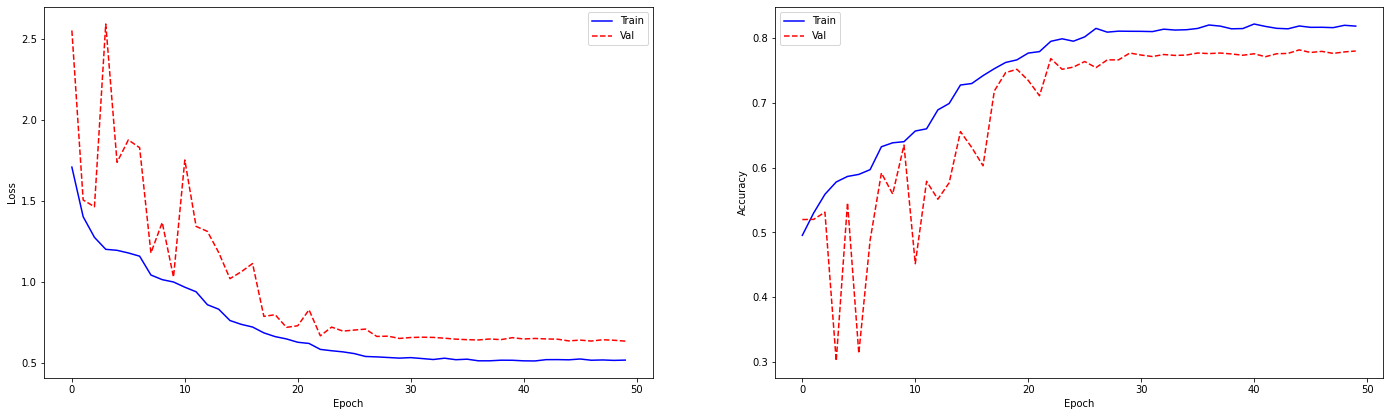

In [31]:
plot_metrics(nn_model_history)

In [32]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [33]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [34]:
# Not applicable for this iteration of modeling

In [35]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [36]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [37]:
test_dataframe = pd.read_csv(labels_dir+TEST_SUBSET_CSV)
test_dataframe['Label'] = test_dataframe['Label'].astype(str)
print(test_dataframe.head())

                Filename Label
0  20160928-141355-0.jpg     0
1  20160928-142103-0.jpg     0
2  20161207-110850-0.jpg     0
3  20161207-111058-0.jpg     0
4  20161207-111159-0.jpg     0


In [38]:
print('Loading and pre-processing the test images...')
test_generator = training_datagen.flow_from_dataframe(test_dataframe,
                                                      directory=data_dir,
                                                      x_col='Filename',
                                                      y_col='Label',
                                                      **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(test_generator))

Loading and pre-processing the test images...
Found 3501 validated image filenames belonging to 9 classes.
Number of image batches per epoch of modeling: 110


In [39]:
final_model = nn_model_0

# Display a summary of the final model
final_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [40]:
# Print the labels used for the modeling
print(test_generator.class_indices)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8}


In [41]:
final_model.evaluate(test_generator, verbose=1)

110/110 [==============================] - 68s 616ms/step - loss: 0.5263 - accuracy: 0.8143


[0.5263139009475708, 0.814338743686676]

In [42]:
# Make batched predictions
test_pred = final_model.predict(validation_generator)
test_predictions = np.argmax(test_pred, axis=-1)
test_original = validation_generator.labels
print('Accuracy Score:', accuracy_score(test_original, test_predictions))
print(confusion_matrix(test_original, test_predictions))
print(classification_report(test_original, test_predictions))

Accuracy Score: 0.7804111936036551
[[ 142    2   11    7    5    6    2   16   34]
 [   9  123    1    4    0    0   28   11   36]
 [   1    0  175    1   25    0    0    0    4]
 [   0    0    6  157   23    0    0    1   18]
 [   0    0   17   10  179    0    0    2    5]
 [   8    1    4    0    1  158    2    2   26]
 [   3    3    0    1    0    1  178    0   29]
 [  50    1    3    1    5    0    2  114   27]
 [  24   12   69   76   57   20   30   26 1507]]
              precision    recall  f1-score   support

           0       0.60      0.63      0.61       225
           1       0.87      0.58      0.69       212
           2       0.61      0.85      0.71       206
           3       0.61      0.77      0.68       205
           4       0.61      0.84      0.70       213
           5       0.85      0.78      0.82       202
           6       0.74      0.83      0.78       215
           7       0.66      0.56      0.61       203
           8       0.89      0.83      0.86  

In [43]:
# # Make a signle prediction
# image_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# image_path = keras.utils.get_file('Red_sunflower', origin=flower_url)

# img = keras.preprocessing.image.load_img(image_path, target_size=INPUT_IMAGE_SIZE)
# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = final_model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print("This image most likely belongs to {} with a {:.2f} percent confidence." .format(class_names[np.argmax(score)], 100 * np.max(score)))

In [44]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [45]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 2:20:01.156345
